# Import Library

In [1]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import pandas as pd
import math

target = 'duration'
categorical = ['PULocationID', 'DOLocationID']

# Downloading the data

In [2]:
df = pd.read_parquet("https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet")

In [3]:
print(df.shape)
df.head()

(3066766, 19)


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3066766 entries, 0 to 3066765
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee           

# Computing duration

In [5]:
df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

In [6]:
df['duration'].std()

42.59435124195458

# Dropping outliers

<Axes: >

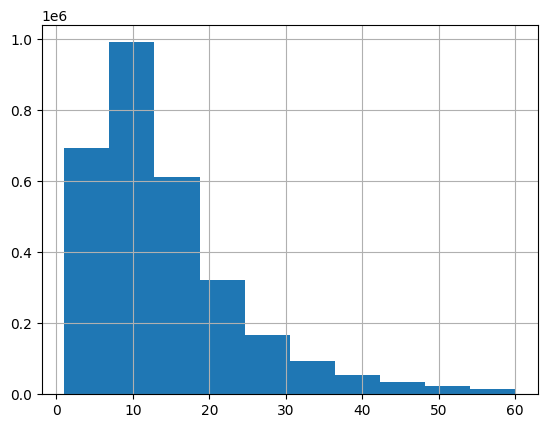

In [7]:
df['duration'].where((df['duration'] > 1) & (df['duration'] < 60)).hist()


In [8]:
len(df[(df['duration'] >= 1) & (df['duration'] <= 60)]) / len(df)
# filter/ all


0.9812202822125979

In [9]:
df = df[(df.duration >= 1) & (df.duration <= 60)]

# One-hot encoding

In [10]:
len(set(df['PULocationID'])), len(set(df['DOLocationID']))

(255, 260)

In [11]:
df['PULocationID'].isna().any() == False & df['DOLocationID'].isna().any() == False

True

In [12]:
df[categorical] = df[categorical].astype(str)

In [13]:
train_dicts = df[categorical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)
y_train = df[target].values

In [14]:
X_train.shape, y_train.shape

((3009173, 515), (3009173,))

# Training a model

In [15]:
lr = LinearRegression(n_jobs=-1)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)



In [16]:
math.sqrt(mean_squared_error(y_train, y_pred))

7.649261931416412

# Evaluating the model

In [17]:
df_val = pd.read_parquet("https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet")

In [18]:
df_val['duration'] = df_val.tpep_dropoff_datetime - df_val.tpep_pickup_datetime
df_val['duration'] = df_val['duration'].apply(lambda td: td.total_seconds() / 60)

In [19]:
df_val = df_val[(df_val.duration >= 1) & (df_val.duration <= 60)]
df_val[categorical] = df_val[categorical].astype(str)

In [20]:
val_dicts = df_val[categorical].to_dict(orient='records')
X_val = dv.transform(val_dicts)
y_val = df_val[target].values
X_val.shape, y_val.shape

((2855951, 515), (2855951,))

In [21]:
y_pred_val = lr.predict(X_val)

math.sqrt(mean_squared_error(y_val, y_pred_val))

7.8118162035401735